# Composite Model

**Purpose:** To show viability in the use of previous promising results. The method using GPR to predict via the model: $HCT+FIB+x\sim\frac{\sigma_{y^0} * \tau_{\lambda}}{\mu_{\infty}}$, where $x$ is the additional variable.

In [1]:
%load_ext autoreload

# Imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
import csv
import warnings
import seaborn as sns
import openpyxl
from scipy import stats

# Ignore warnings
warnings.filterwarnings("ignore")

# Sklearn Imports
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import clone

# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'nn_webserver'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

# Add Project Working Directory to Path
##sys.path.append(r'C:\Users\manni\OneDrive - University of Delaware - o365\Python Projects\TransientBloodRheo_ML\codePackage')
sys.path.append(r'/home/msmitty/Documents/TransientBloodRheo_ML/codePackage')
from supporting_functions import get_fp, loadData, saveData

# Seed
seed = 1743
np.random.seed(seed)

# Get Correct Filepath
#cpu = "surface"
cpu = "man_dtop"
#cpu = "sean"
folder_fp, data_fp, figures_fp = get_fp(cpu, figuresFolder="6.viability\\")

# Get Data
rawPhys, rawRheo, physDict, rheoDict, imputedRheo = loadData(data_fp)

    
# Subset
# Base variables (always included)
base_vars = ['HCT', 'FIB']

# Additional variables to test (one at a time with base)
abrSubset = ['donors', 'CHOL', 'TRIG', 'HDL', 'LDL', 'WBC', 'RBC', 'HEM', 'MCV', 'MCH', 'MCHC', 'FIB', 'HCT']


# Create a Mapping
rename_mapping = {}
for full_name, props in physDict.items():
    abbr = props.get('abbreviation')
    if abbr in abrSubset:
        rename_mapping[physDict[full_name]["column_name"]] = abbr
        
# Rename the columns
subset_Phys = rawPhys.rename(columns=rename_mapping)
subset_Phys = subset_Phys[abrSubset]

# Define Targets
rheo_targets = ["MU_INF", "SIGMA_Y0", "TAU_LAM"]
rheo_targets_latex = [r"$\mu_{\infinity}$", r"$\sigma_{Y^{0}}$", r"$\tau_{\lambda}$"]
rheo_columns = [value["column_name"] for value in rheoDict.values()][1::]

# Define Donors
donors = rawRheo['donors'].values

In [2]:
# Remove Null
rheo_clean = rawRheo.dropna(subset=rheo_columns).copy()[['donors', 'mu_inf (Pa s)', 'tau_lam (s)', 'sigma_y0 (Pa)']]

composite_variable = (rheo_clean['sigma_y0 (Pa)'] * rheo_clean['tau_lam (s)']) / rheo_clean['mu_inf (Pa s)']
composite_name = "Composite Variable"

# Create composite DataFrame
comp_df = pd.DataFrame({
    'donors': rheo_clean['donors'],  # Column from existing dataframe
    'composite_variable': composite_variable              # Your array of values
})

# Merge with subset_Phys
merged_df = pd.merge(subset_Phys, comp_df, left_index=True, right_index=True, how='right')
# Rename 'donors_x' to 'donors_'
merged_df = merged_df.rename(columns={'donors_x': 'donors_'})
merged_df

# Create all combinations
feature_combinations = []
for add_var in abrSubset:
    if add_var == 'donors':
        continue
    combination = base_vars + [add_var]
    feature_combinations.append({
        'name': f"HCT+FIB+{add_var}",
        'variables': combination,
        'additional_var': add_var
    })

In [3]:
def evaluate_model_performance(X, y, seed=1743):
    """
    Evaluate model performance using cross-validation
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Store predictions for each fold
    y_pred_cv = np.full_like(y, np.nan)
    
    # Perform cross-validation
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit model
        #"""
        model = GaussianProcessRegressor(
            kernel=RBF(1.0) + WhiteKernel(0.1),
            alpha = 5.0,
            normalize_y=True,
            n_restarts_optimizer=1,
            random_state=seed
        )
        model.fit(X_train_scaled, y_train)
        #"""
        
        #'Ridge': Ridge(alpha=0.1, random_state=seed)
        #model = Ridge(alpha=0.1, random_state=seed)
        #model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred_cv[test_idx] = model.predict(X_test_scaled)
    
    # Calculate metrics
    r2_cv = r2_score(y, y_pred_cv)
    mse_cv = mean_squared_error(y, y_pred_cv)
    mae_cv = mean_absolute_error(y, y_pred_cv)
    
    # Train on full dataset for training metrics
    scaler_full = StandardScaler()
    X_scaled_full = scaler_full.fit_transform(X)
    model.fit(X_scaled_full, y)
    y_pred_train = model.predict(X_scaled_full)
    r2_train = r2_score(y, y_pred_train)
    
    return {
        'r2_cv': r2_cv,
        'r2_train': r2_train,
        'mse_cv': mse_cv,
        'mae_cv': mae_cv,
        'overfitting': r2_train - r2_cv,
        'y_pred_cv': y_pred_cv,
        'y_pred_train': y_pred_train
    }

results = {}
for m in feature_combinations:
    vars = m['variables'].copy()
    vars.append('composite_variable')
    data = merged_df[vars].dropna()
    # Everything but the last variable is a feature, the last is the target
    X = data[vars[:-1]]
    y = data[vars[-1]]
    results[m['name']] = evaluate_model_performance(X.reset_index(drop=True), y.reset_index(drop=True), seed)

In [4]:
# Convert results dictionary to DataFrame
results_list = []
for combo_name, metrics in results.items():
    row = {'combination': combo_name}
    row.update(metrics)
    results_list.append(row)

df_results = pd.DataFrame(results_list)

# Add additional variable column
df_results['additional_var'] = df_results['combination'].str.split('+').str[-1]

# Drop prediction arrays (optional - remove this line if you want to keep them)
df = df_results.drop(['y_pred_cv', 'y_pred_train'], axis=1, errors='ignore')

# Sort by R²_CV performance
df_results = df.sort_values('r2_cv', ascending=False).reset_index(drop=True)

In [5]:
df_results

,combination,r2_cv,r2_train,mse_cv,mae_cv,overfitting,additional_var
0,HCT+FIB+LDL,-0.214640,2.101467e-07,0.380494,0.518180,0.214640,LDL
1,HCT+FIB+HEM,-0.222469,4.394674e-11,0.382946,0.529530,0.222469,HEM
2,HCT+FIB+CHOL,-0.224450,5.780024e-07,0.383567,0.529266,0.224450,CHOL
3,HCT+FIB+RBC,-0.224450,5.095562e-07,0.383567,0.529266,0.224450,RBC
4,HCT+FIB+MCH,-0.224450,2.249668e-08,0.383567,0.529266,0.224450,MCH
5,HCT+FIB+TRIG,-0.224450,7.167546e-07,0.383567,0.529266,0.224451,TRIG
6,HCT+FIB+MCHC,-0.224450,3.691967e-10,0.383567,0.529266,0.224450,MCHC
7,HCT+FIB+HDL,-0.224450,3.247920e-07,0.383567,0.529266,0.224450,HDL
8,HCT+FIB+HCT,-0.225369,1.970706e-07,0.383855,0.530801,0.225369,HCT
9,HCT+FIB+MCV,-0.227079,3.533500e-07,0.384390,0.531299,0.227080,MCV


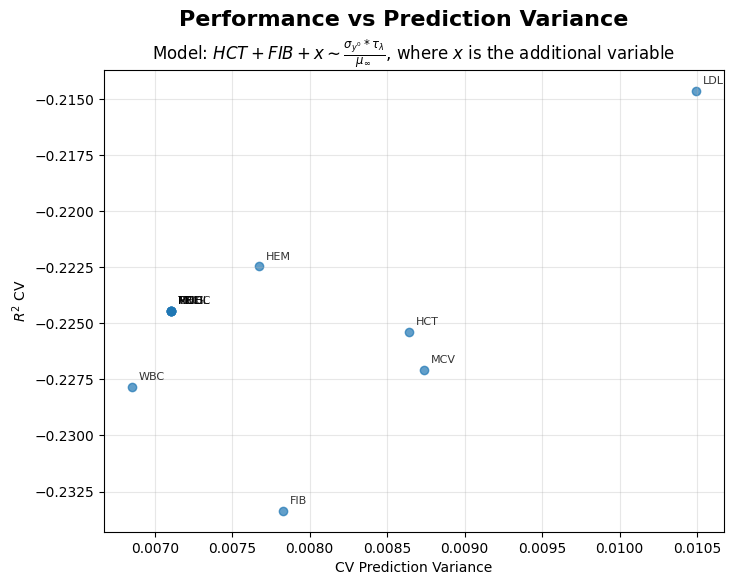

In [6]:
# Plot 3: R2 vs prediction variance with labels
cv_variances = [np.var(results[combo]['y_pred_cv']) for combo in df_results['combination']]
plt.figure(figsize=(8, 6))
plt.scatter(cv_variances, df_results['r2_cv'], alpha=0.7)

# Add labels for each point
for i, combo in enumerate(df_results['combination']):
    # Extract the additional variable name (assuming it's the last variable added)
    additional_var = df_results['additional_var'].iloc[i]
    plt.annotate(additional_var, 
                (cv_variances[i], df_results['r2_cv'].iloc[i]),
                xytext=(5, 5),  # Offset the text slightly
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

plt.xlabel('CV Prediction Variance')
plt.ylabel(r'$R^2$ CV')
plt.suptitle('Performance vs Prediction Variance', fontsize=16, fontweight='bold')  # Main title
# (rheo_clean['sigma_y0 (Pa)'] * rheo_clean['tau_lam (s)']) / rheo_clean['mu_inf (Pa s)']
plt.title(r'Model: $HCT+FIB+x\sim\frac{\sigma_{y^0} * \tau_{\lambda}}{\mu_{\infty}}$, where $x$ is the additional variable', fontsize=12) 
plt.grid(True, alpha=0.3)
fp = figures_fp + 's6_0XX_combinationModelPerformance.png'
plt.savefig(fp, dpi=300, bbox_inches='tight')
plt.show()

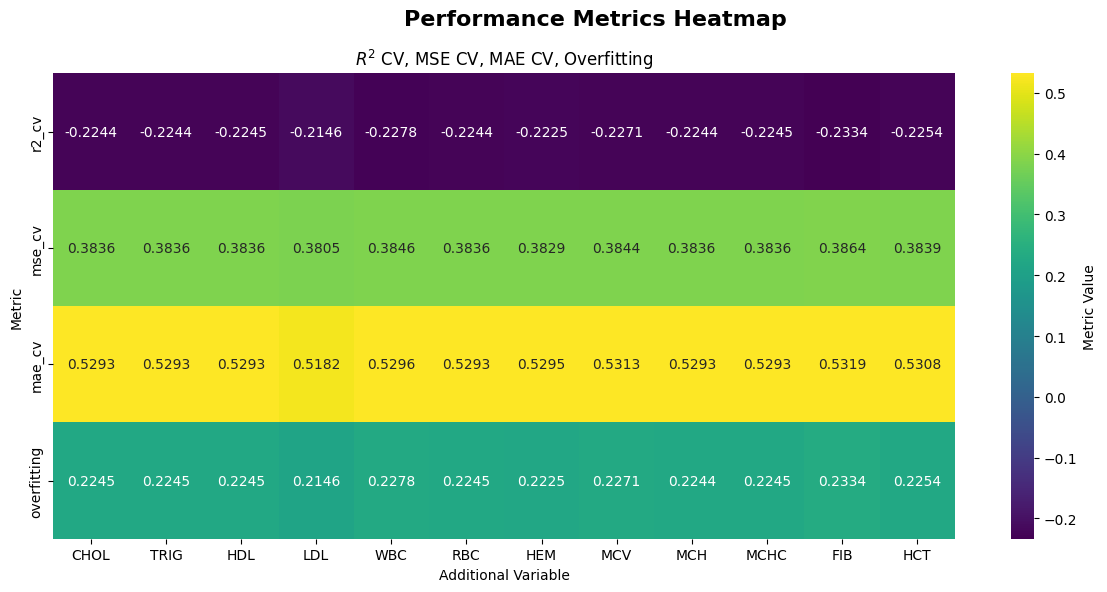

In [7]:
# Create heatmap data
heatmap_data = df[['additional_var', 'r2_cv', 'mse_cv', 'mae_cv', 'overfitting']].copy()
# Pivot for heatmap (transpose so variables are on y-axis)
heatmap_matrix = heatmap_data.set_index('additional_var').T

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_matrix, 
            annot=True, 
            fmt='.4f', 
            cmap='viridis', 
            cbar_kws={'label': 'Metric Value'})

plt.suptitle('Performance Metrics Heatmap', fontsize=16, fontweight='bold')
plt.title(r'$R^2$ CV, MSE CV, MAE CV, Overfitting', fontsize=12)
plt.xlabel('Additional Variable')
plt.ylabel('Metric')
plt.tight_layout()
fp = figures_fp + 's6_0XX_performanceHeatmap.png'
plt.savefig(fp, dpi=300, bbox_inches='tight')
plt.show()